In [1]:
from multiprocessing.spawn import freeze_support
import torchvision
import os
import torchvision.models.alexnet
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets
import torch.nn as nn
import torchvision.models.vgg
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE

# base to base code - https://github.com/fyu/drn
# base paper - https://arxiv.org/pdf/1712.02560.pdf
# base code - https://github.com/mil-tokyo/MCD_DA/tree/master/classification
# our implementation - https://github.com/Nyn-ynu/MCD

In [2]:
dataset_root = "dataset"
batch_size = 256
num_workers = 4
device = "cuda"
lr = 1e-4
N = 10
num_epoch = 100
# num_epoch = 2
models_save = "models_trained"
criterion = nn.CrossEntropyLoss()

In [3]:
class LeNetClassifier(nn.Module):
    def __init__(self, prob=0.5):
          super(LeNetClassifier, self).__init__()
          self.fc1 = nn.Linear(48*4*4, 100)
          self.bn1_fc = nn.BatchNorm1d(100)
          self.fc2 = nn.Linear(100, 100)
          self.bn2_fc = nn.BatchNorm1d(100)
          self.fc3 = nn.Linear(100, 10)
          self.bn_fc3 = nn.BatchNorm1d(10)
          self.prob = prob

    def set_lambda(self, lambd):
        self.lambd = lambd
    def forward(self, x):
        x = F.dropout(x, training=self.training, p=self.prob)
        x = F.relu(self.bn1_fc(self.fc1(x)))
        x = F.dropout(x, training=self.training, p=self.prob)
        x = F.relu(self.bn2_fc(self.fc2(x)))
        x = F.dropout(x, training=self.training, p=self.prob)
        x = self.fc3(x)
        return x

In [4]:
class ClassifierVgg(nn.Module):
    def __init__(self, num_classes=31):
        super(ClassifierVgg, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.classifier(x)
        return x

In [5]:
class LeNetEncoder(nn.Module):
    """LeNet encoder model for ADDA."""

    def __init__(self):
      super(LeNetEncoder, self).__init__()
      self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1)
      self.bn1 = nn.BatchNorm2d(32)
      self.conv2 = nn.Conv2d(32, 48, kernel_size=5, stride=1)
      self.bn2 = nn.BatchNorm2d(48)

    def forward(self, x):
        x = torch.mean(x,1).view(x.size()[0],1,x.size()[2],x.size()[3])
        x = F.max_pool2d(F.relu(self.bn1(self.conv1(x))), stride=2, kernel_size=2, dilation=(1, 1))
        x = F.max_pool2d(F.relu(self.bn2(self.conv2(x))), stride=2, kernel_size=2, dilation=(1, 1))
        #print(x.size())
        x = x.view(x.size(0), 48*4*4)
        return x


In [6]:
import torch.nn as nn
import torch


class VGG(nn.Module):

    def __init__(self, features, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(cfg, batch_norm, **kwargs):

    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)

    return model


def vgg_Extractor():
    return _vgg('E', False)




In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(28),
    torchvision.transforms.ToTensor()
])

In [8]:
def get_data(data_name, transform, is_train=True):
    if data_name =="mnist":
        data_loader = datasets.MNIST(root=dataset_root, train=is_train, download=True, transform=transform)
    elif data_name == "svhn":
        data_loader = datasets.SVHN(root=dataset_root, download=True, transform=transform)
    elif data_name == "usps":
        data_loader = datasets.USPS(root=dataset_root, train=is_train, download=True, transform=transform)
    
    data = DataLoader(dataset=data_loader, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    return data


In [9]:
src_train_data = get_data("mnist", transform=transform)
src_train_data2 = get_data("svhn", transform=transform)
tgt_train_data = get_data("usps", transform=transform)

src_test_data = get_data("mnist", transform=transform, is_train=False)
src_test_data2 = get_data("svhn", transform=transform, is_train=False)
tgt_test_data = get_data("usps", transform=transform, is_train=False)

Using downloaded and verified file: dataset/train_32x32.mat
Using downloaded and verified file: dataset/train_32x32.mat


In [10]:
mnist = datasets.MNIST(root=dataset_root, train=False, download=True, transform=transform)

usps = datasets.USPS(root=dataset_root, train=False, download=True, transform=transform)

mnistx = []
for i in range (1000):
    mnistx.append(mnist[i])

img_array = []
label_array = []
for data in mnistx:
    img = data[0].reshape(784)
    label = int(data[1])
    img_array.append(img.numpy())
    label_array.append(label)


uspsx = []
for i in range (1000):
    uspsx.append(usps[i])
    

img_array2 = []
label_array2 = []
for data in uspsx:
    img = data[0].reshape(784)
    label = int(data[1])
    img_array2.append(img.numpy())
    label_array2.append(label)
    

tsne = TSNE(n_components=2, random_state=0)
tsne_data = tsne.fit_transform(img_array)


tsne2 = TSNE(n_components=2, random_state=0)
tsne_data2 = tsne2.fit_transform(img_array2)

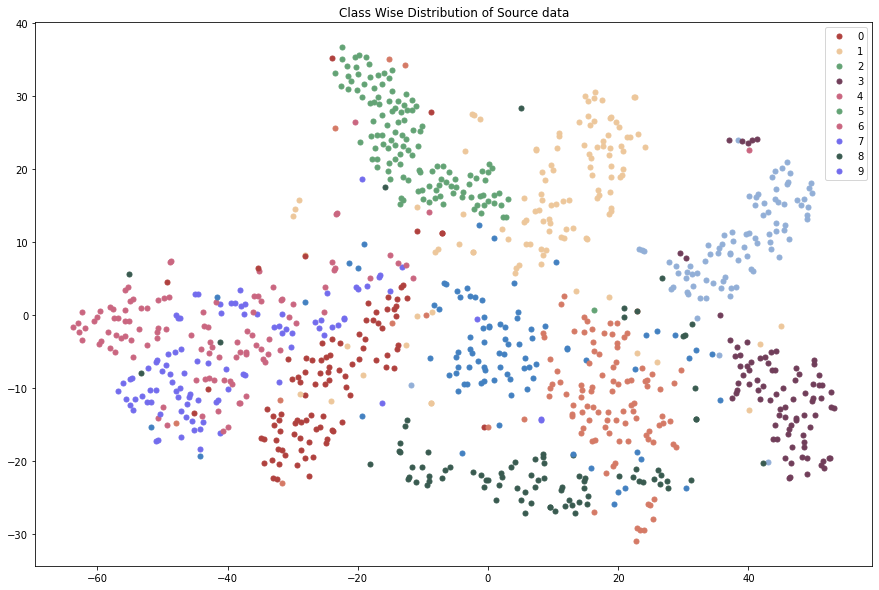

In [11]:
colordot=['#713e5a', '#63a375', '#edc79b', '#d57a66', '#ca6680', '#395B50', '#92AFD7', '#b0413e', '#4381c1', '#736ced']
plt.subplots(figsize=(15,10))
for i in range(1000):
    plt.plot(tsne_data[i,0],tsne_data[i,1],"o",markersize=5, color = colordot[label_array[i]])
plt.legend(["0","1","2","3","4","5","6","7","8","9"], loc ="upper right")
plt.title("Class Wise Distribution of Source data")
plt.savefig('srcplot.png')
plt.show()

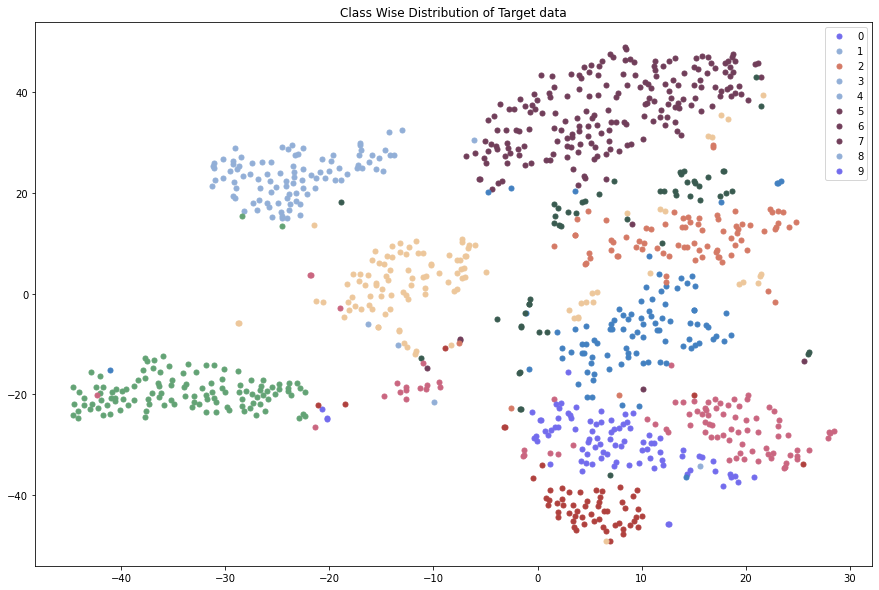

In [12]:
colordot=['#713e5a', '#63a375', '#edc79b', '#d57a66', '#ca6680', '#395B50', '#92AFD7', '#b0413e', '#4381c1', '#736ced']
plt.subplots(figsize=(15,10))
for i in range(1000):
    plt.plot(tsne_data2[i,0],tsne_data2[i,1],"o",markersize=5, color = colordot[label_array2[i]])
plt.legend(["0","1","2","3","4","5","6","7","8","9"], loc ="upper right")
plt.title("Class Wise Distribution of Target data")
plt.savefig('tgtplot.png')
plt.show()

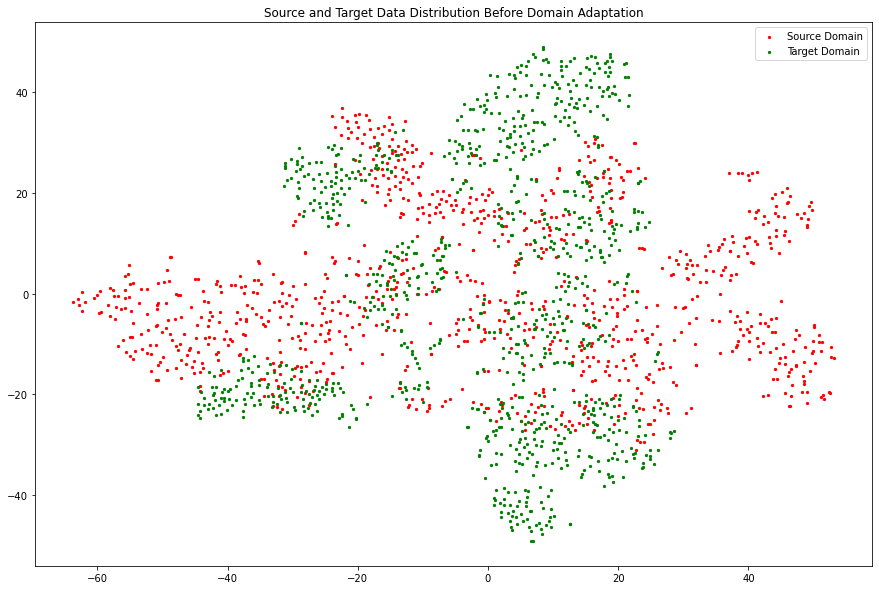

In [13]:
plt.subplots(figsize=(15,10))
plt.scatter(tsne_data[:,0],tsne_data[:,1],color="red", s=5)
plt.scatter(tsne_data2[:,0],tsne_data2[:,1],color="green",s=5)
plt.legend(["Source Domain", "Target Domain"], loc ="upper right")
plt.title("Source and Target Data Distribution Before Domain Adaptation")
plt.savefig('src_tgt_data_distribution.png')
plt.show()

In [ ]:
# for b_no, b_data in enumerate(src_train_data):
#     print("Batch No.",b_no)
#     b_len=len(b_data[0])
#     for i in range(b_len):
#         image = b_data[0][i]
#         label = int(b_data[1][i])
#         plt.imshow(image.permute(1,2,0))
#         print("Label:",label)
#         break
#     break

In [14]:
def init_weights(m):
    if type(m) == nn.Conv2d:
        nn.init.orthogonal_(m.weight)
    if type(m) == nn.Linear:
        nn.init.orthogonal_(m.weight)

In [15]:
extractor_a = LeNetEncoder()
classifier_a1 = LeNetClassifier()
classifier_a2 = LeNetClassifier()

extractor_a.apply(init_weights)
classifier_a1.apply(init_weights)
classifier_a2.apply(init_weights)

LeNetClassifier(
  (fc1): Linear(in_features=768, out_features=100, bias=True)
  (bn1_fc): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (bn2_fc): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (bn_fc3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [16]:
extractor_b = LeNetEncoder()
classifier_b1 = LeNetClassifier()
classifier_b2 = LeNetClassifier()

extractor_b.apply(init_weights)
classifier_b1.apply(init_weights)
classifier_b2.apply(init_weights)

LeNetClassifier(
  (fc1): Linear(in_features=768, out_features=100, bias=True)
  (bn1_fc): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (bn2_fc): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (bn_fc3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [17]:
# Loss function
def discrepancy(out1, out2):
    return torch.mean(torch.abs(F.softmax(out1)- F.softmax(out2)))

In [18]:
def train_nda(src_data, tgt_data, extractor, classifier1, classifier2):
    extractor.train()   
    classifier1.train()
    classifier2.train()
    extractor.to(device)
    classifier1.to(device)
    classifier2.to(device)

    data = enumerate(zip(src_data, tgt_data))
    opt_e = torch.optim.Adam(extractor.parameters(), lr=lr)
    opt_c1 = torch.optim.Adam(classifier1.parameters(), lr=lr)
    opt_c2 = torch.optim.Adam(classifier2.parameters(), lr=lr)
    # Out of the loop
    len_dataloader = min(len(src_data), len(tgt_data))
    
    for idx, ((src_img, src_labels), (tgt_img, _)) in data:
        if idx > len_dataloader:
            break

        src_img = src_img.to(device)
        tgt_img = tgt_img.to(device)
        src_labels = src_labels.to(device)
        '''
        STEP A
        '''
        opt_e.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()

        src_feat = extractor(src_img)
        preds_s1 = classifier1(src_feat)
        preds_s2 = classifier2(src_feat)

        loss_A = criterion(preds_s1, src_labels) + criterion(preds_s2, src_labels)
        loss_A.backward()

        opt_e.step()
        opt_c1.step()
        opt_c2.step()
        
        if (idx+1) % 10 == 0:
            print("loss = {:.2f}".format(loss_A.item()))
    return extractor, classifier1, classifier2

In [19]:
def test_nda(data, extractor, classifier1, classifier2):
    acc1 = 0
    acc2 = 0

    check = True
    for img, labels in data:
        img = img.to(device)
        labels = labels.to(device)
        img_feat = extractor(img)
        preds1 = classifier1(img_feat)
        preds2 = classifier2(img_feat)

        acc1 += (preds1.argmax(dim=1) == labels).sum().item()
        acc2 += (preds2.argmax(dim=1) == labels).sum().item()

    print("acc1={:.2%}, acc2={:.2%}".format(acc1/len(data.dataset), acc2/len(data.dataset)))

In [20]:
def test_and_plot_nda(data1, data2, extractor, classifier1, classifier2):
    #for source data 
    features = []
    acc1 = 0
    acc2 = 0
    
    for img, labels in data1:
        img = img.to(device)
        labels = labels.to(device)
        img_feat = extractor(img)
        features.append(img_feat.cpu().detach().numpy())

        preds1 = classifier1(img_feat)
        preds2 = classifier2(img_feat)

        acc1 += (preds1.argmax(dim=1) == labels).sum().item()
        acc2 += (preds2.argmax(dim=1) == labels).sum().item()

    print("acc1={:.2%}, acc2={:.2%}".format(acc1/len(data1.dataset), acc2/len(data1.dataset)))
    
    features = np.array(features)
    
    featurex = []
    
    for batch_features in features:
        for indvidual_features in batch_features:
            featurex.append(indvidual_features)

    tsne3 = TSNE(n_components=2, random_state=0)
    tsne_data3 = tsne3.fit_transform(featurex)

    
    plt.subplots(figsize=(15,10))
    for i in range(1000):
        plt.plot(tsne_data3[i,0],tsne_data3[i,1],"o",markersize=5, color = "red")
    
    
    #for tgt data 
    features = []
    acc1 = 0
    acc2 = 0
    
    for img, labels in data2:
        img = img.to(device)
        labels = labels.to(device)
        img_feat = extractor(img)
        features.append(img_feat.cpu().detach().numpy())

        preds1 = classifier1(img_feat)
        preds2 = classifier2(img_feat)

        acc1 += (preds1.argmax(dim=1) == labels).sum().item()
        acc2 += (preds2.argmax(dim=1) == labels).sum().item()

    print("acc1={:.2%}, acc2={:.2%}".format(acc1/len(data2.dataset), acc2/len(data2.dataset)))
    
    features = np.array(features)

    
    featurex = []
    
    for batch_features in features:
        for indvidual_features in batch_features:
            featurex.append(indvidual_features)

    tsne3 = TSNE(n_components=2, random_state=0)
    tsne_data3 = tsne3.fit_transform(featurex)

    
    for i in range(1000):
        plt.plot(tsne_data3[i,0],tsne_data3[i,1],"o",markersize=5, color = "green")
        
        
    plt.legend(["src","tgt"], loc ="upper right")
    plt.title("Before Domain Adaptation")
    plt.savefig('before_domain_adaptaion.png')
    plt.show()

In [21]:
def train(src_data, tgt_data, extractor, classifier1, classifier2):
    extractor.train()   
    classifier1.train()
    classifier2.train()
    extractor.to(device)
    classifier1.to(device)
    classifier2.to(device)

    data = enumerate(zip(src_data, tgt_data))
    opt_e = torch.optim.Adam(extractor.parameters(), lr=lr)
    opt_c1 = torch.optim.Adam(classifier1.parameters(), lr=lr)
    opt_c2 = torch.optim.Adam(classifier2.parameters(), lr=lr)
    # Out of the loop
    len_dataloader = min(len(src_data), len(tgt_data))
    for idx, ((src_img, src_labels), (tgt_img, _)) in data:
        if idx > len_dataloader:
            break

        src_img = src_img.to(device)
        tgt_img = tgt_img.to(device)
        src_labels = src_labels.to(device)
        '''
        STEP A
        '''
        opt_e.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()

        src_feat = extractor(src_img)
        preds_s1 = classifier1(src_feat)
        preds_s2 = classifier2(src_feat)

        loss_A = criterion(preds_s1, src_labels) + criterion(preds_s2, src_labels)
        loss_A.backward()

        opt_e.step()
        opt_c1.step()
        opt_c2.step()

        '''
        STEP B
        '''
        opt_e.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()

        src_feat = extractor(src_img)
        preds_s1 = classifier1(src_feat)
        preds_s2 = classifier2(src_feat)

        src_tgt = extractor(tgt_img)
        preds_t1 = classifier1(src_tgt)
        preds_t2 = classifier2(src_tgt)

        loss_B = criterion(preds_s1, src_labels) + criterion(preds_s2, src_labels) - discrepancy(preds_t1, preds_t2)
        loss_B.backward()

        opt_c1.step()
        opt_c2.step()

        opt_e.zero_grad()
        opt_c1.zero_grad()
        opt_c2.zero_grad()

        '''
        STEP C
        '''
        for i in range(N):
            feat_tgt = extractor(tgt_img)
            preds_t1 = classifier1(feat_tgt)
            preds_t2 = classifier1(feat_tgt)
            loss_C = discrepancy(preds_t1, preds_t2)
            loss_C.backward()
            opt_e.step()

            opt_e.zero_grad()
            opt_c1.zero_grad()
            opt_c2.zero_grad()

        if (idx+1) % 10 == 0:
            print("loss_A = {:.2f}, loss_B = {:.2f}, loss_C = {:.2f}".format(loss_A.item(), loss_B.item(), loss_C.item()))
    return extractor, classifier1, classifier2

In [22]:
def test(data, extractor, classifier1, classifier2):
    acc1 = 0
    acc2 = 0

    check = True
    for img, labels in data:
        img = img.to(device)
        labels = labels.to(device)
        img_feat = extractor(img)
        preds1 = classifier1(img_feat)
        preds2 = classifier2(img_feat)

        acc1 += (preds1.argmax(dim=1) == labels).sum().item()
        acc2 += (preds2.argmax(dim=1) == labels).sum().item()

    print("acc1={:.2%}, acc2={:.2%}".format(acc1/len(data.dataset), acc2/len(data.dataset)))

In [23]:
def test_and_plot(data1, data2, extractor, classifier1, classifier2):
    #for source data 
    features = []
    acc1 = 0
    acc2 = 0
    
    for img, labels in data1:
        img = img.to(device)
        labels = labels.to(device)
        img_feat = extractor(img)
        features.append(img_feat.cpu().detach().numpy())

        preds1 = classifier1(img_feat)
        preds2 = classifier2(img_feat)

        acc1 += (preds1.argmax(dim=1) == labels).sum().item()
        acc2 += (preds2.argmax(dim=1) == labels).sum().item()

    print("acc1={:.2%}, acc2={:.2%}".format(acc1/len(data1.dataset), acc2/len(data1.dataset)))
    
    features = np.array(features)
    
    featurex = []
    
    for batch_features in features:
        for indvidual_features in batch_features:
            featurex.append(indvidual_features)

    tsne3 = TSNE(n_components=2, random_state=0)
    tsne_data3 = tsne3.fit_transform(featurex)

    
    plt.subplots(figsize=(15,10))
    for i in range(1000):
        plt.plot(tsne_data3[i,0],tsne_data3[i,1],"o",markersize=5, color = "red")
    
    
    #for tgt data 
    features = []
    acc1 = 0
    acc2 = 0
    
    for img, labels in data2:
        img = img.to(device)
        labels = labels.to(device)
        img_feat = extractor(img)
        features.append(img_feat.cpu().detach().numpy())

        preds1 = classifier1(img_feat)
        preds2 = classifier2(img_feat)

        acc1 += (preds1.argmax(dim=1) == labels).sum().item()
        acc2 += (preds2.argmax(dim=1) == labels).sum().item()

    print("acc1={:.2%}, acc2={:.2%}".format(acc1/len(data2.dataset), acc2/len(data2.dataset)))
    
    features = np.array(features)

    
    featurex = []
    
    for batch_features in features:
        for indvidual_features in batch_features:
            featurex.append(indvidual_features)

    tsne3 = TSNE(n_components=2, random_state=0)
    tsne_data3 = tsne3.fit_transform(featurex)

    
    for i in range(1000):
        plt.plot(tsne_data3[i,0],tsne_data3[i,1],"o",markersize=5, color = "green")
        
        
    plt.legend(["src","tgt"], loc ="upper right")
    plt.title("After Domain Adaptation")
    plt.savefig('after_domain_adaptaion.png')
    plt.show()

epoch=0
loss = 5.39
loss = 5.08


/home/akash/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akash/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNetClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


acc1=15.11%, acc2=14.69%
acc1=11.51%, acc2=13.75%
epoch=1
loss = 4.63
loss = 4.67
acc1=21.95%, acc2=20.50%
acc1=15.99%, acc2=18.24%
epoch=2
loss = 4.47
loss = 4.06
acc1=28.14%, acc2=27.05%
acc1=19.98%, acc2=23.22%
epoch=3
loss = 3.93
loss = 3.97
acc1=34.82%, acc2=33.41%
acc1=24.56%, acc2=25.26%
epoch=4
loss = 3.81
loss = 3.63
acc1=41.20%, acc2=39.40%
acc1=27.70%, acc2=29.35%
epoch=5
loss = 3.41
loss = 3.37
acc1=45.95%, acc2=45.13%
acc1=31.84%, acc2=31.74%
epoch=6
loss = 3.19
loss = 3.07
acc1=51.24%, acc2=50.01%
acc1=35.43%, acc2=33.43%
epoch=7
loss = 2.89
loss = 2.86
acc1=55.10%, acc2=53.69%
acc1=37.32%, acc2=39.81%
epoch=8
loss = 2.88
loss = 2.77
acc1=59.35%, acc2=58.90%
acc1=38.27%, acc2=39.21%
epoch=9
loss = 2.71
loss = 2.50
acc1=62.27%, acc2=61.83%
acc1=41.75%, acc2=44.15%
epoch=10
loss = 2.34
loss = 2.37
acc1=65.81%, acc2=64.88%
acc1=43.60%, acc2=45.04%
epoch=11
loss = 2.27
loss = 2.19
acc1=68.13%, acc2=68.07%
acc1=46.24%, acc2=45.84%
epoch=12
loss = 2.12
loss = 2.01
acc1=71.18%, 

loss = 0.37
acc1=95.99%, acc2=95.68%


/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


acc1=71.75%, acc2=72.30%


/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


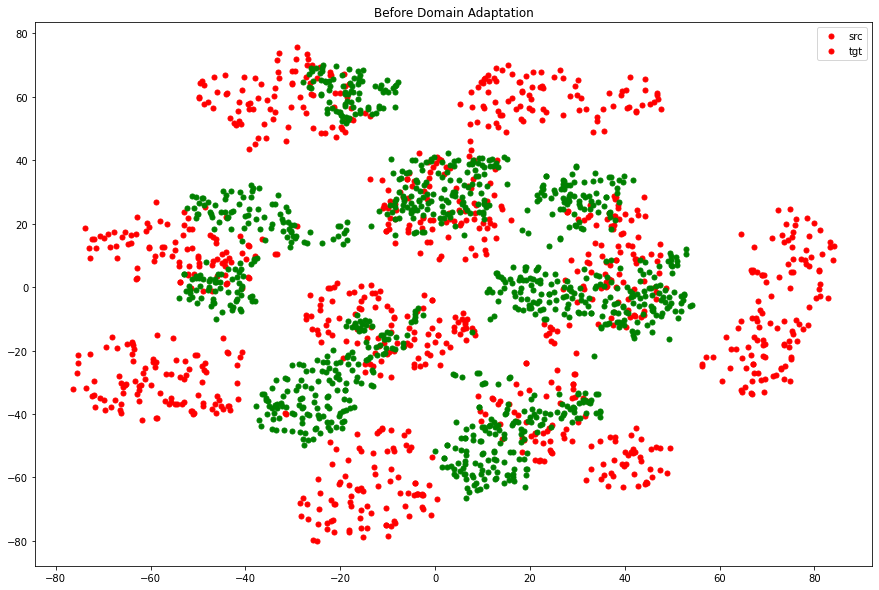

In [25]:
#without domain adaptation
for i in range(num_epoch):
        print("epoch={}".format(i))
        extractor_a, classifier_a1, classifier_a2 = train_nda(src_train_data, tgt_train_data, extractor_a, classifier_a1, classifier_a2)

        torch.save(extractor_a, os.path.join(models_save, "extractor_a.pth"))
        torch.save(classifier_a1, os.path.join(models_save, "classifier_a1.pth"))
        torch.save(classifier_a2, os.path.join(models_save, "classifier_a2.pth"))

        if(i<num_epoch-1):
            # Source domain test
            test_nda(src_test_data, extractor_a, classifier_a1, classifier_a2)
            # Target domain test
            test_nda(tgt_test_data, extractor_a, classifier_a1, classifier_a2)
        else:
             # Source and target test and plot
            test_and_plot_nda(src_test_data, tgt_test_data, extractor_a, classifier_a1, classifier_a2)

epoch=0


/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


loss_A = 4.84, loss_B = 4.84, loss_C = 0.08
loss_A = 4.54, loss_B = 4.51, loss_C = 0.08


/home/akash/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNetEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/akash/anaconda3/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type LeNetClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


acc1=24.99%, acc2=27.35%
acc1=20.48%, acc2=21.57%
epoch=1
loss_A = 3.98, loss_B = 3.85, loss_C = 0.08
loss_A = 3.86, loss_B = 3.69, loss_C = 0.08
acc1=37.83%, acc2=39.80%
acc1=27.85%, acc2=28.45%
epoch=2
loss_A = 3.33, loss_B = 3.29, loss_C = 0.08
loss_A = 3.30, loss_B = 3.23, loss_C = 0.08
acc1=48.09%, acc2=50.50%
acc1=33.38%, acc2=35.97%
epoch=3
loss_A = 2.99, loss_B = 2.88, loss_C = 0.08
loss_A = 2.93, loss_B = 2.73, loss_C = 0.08
acc1=58.07%, acc2=59.37%
acc1=39.56%, acc2=38.42%
epoch=4
loss_A = 2.54, loss_B = 2.58, loss_C = 0.08
loss_A = 2.52, loss_B = 2.37, loss_C = 0.07
acc1=64.75%, acc2=65.63%
acc1=43.60%, acc2=42.35%
epoch=5
loss_A = 2.30, loss_B = 2.24, loss_C = 0.08
loss_A = 2.23, loss_B = 2.09, loss_C = 0.08
acc1=70.33%, acc2=71.92%
acc1=47.14%, acc2=49.13%
epoch=6
loss_A = 2.00, loss_B = 1.94, loss_C = 0.08
loss_A = 1.89, loss_B = 1.77, loss_C = 0.08
acc1=74.69%, acc2=75.08%
acc1=50.77%, acc2=51.42%
epoch=7
loss_A = 1.73, loss_B = 1.55, loss_C = 0.07
loss_A = 1.58, loss_B 

acc1=96.73%, acc2=96.66%
acc1=91.23%, acc2=90.93%
epoch=57
loss_A = 0.21, loss_B = 0.19, loss_C = 0.02
loss_A = 0.26, loss_B = 0.21, loss_C = 0.02
acc1=96.97%, acc2=96.74%
acc1=91.33%, acc2=90.18%
epoch=58
loss_A = 0.34, loss_B = 0.29, loss_C = 0.02
loss_A = 0.20, loss_B = 0.20, loss_C = 0.02
acc1=96.62%, acc2=96.58%
acc1=90.53%, acc2=90.98%
epoch=59
loss_A = 0.25, loss_B = 0.27, loss_C = 0.02
loss_A = 0.30, loss_B = 0.19, loss_C = 0.02
acc1=96.97%, acc2=96.83%
acc1=91.03%, acc2=90.08%
epoch=60
loss_A = 0.22, loss_B = 0.19, loss_C = 0.02
loss_A = 0.23, loss_B = 0.19, loss_C = 0.02
acc1=96.94%, acc2=96.68%
acc1=90.48%, acc2=90.83%
epoch=61
loss_A = 0.23, loss_B = 0.17, loss_C = 0.02
loss_A = 0.32, loss_B = 0.27, loss_C = 0.02
acc1=96.85%, acc2=96.94%
acc1=90.93%, acc2=90.83%
epoch=62
loss_A = 0.24, loss_B = 0.22, loss_C = 0.02
loss_A = 0.19, loss_B = 0.27, loss_C = 0.02
acc1=96.84%, acc2=96.89%
acc1=90.28%, acc2=90.98%
epoch=63
loss_A = 0.12, loss_B = 0.08, loss_C = 0.02
loss_A = 0.38, 

/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


acc1=92.53%, acc2=93.07%


/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


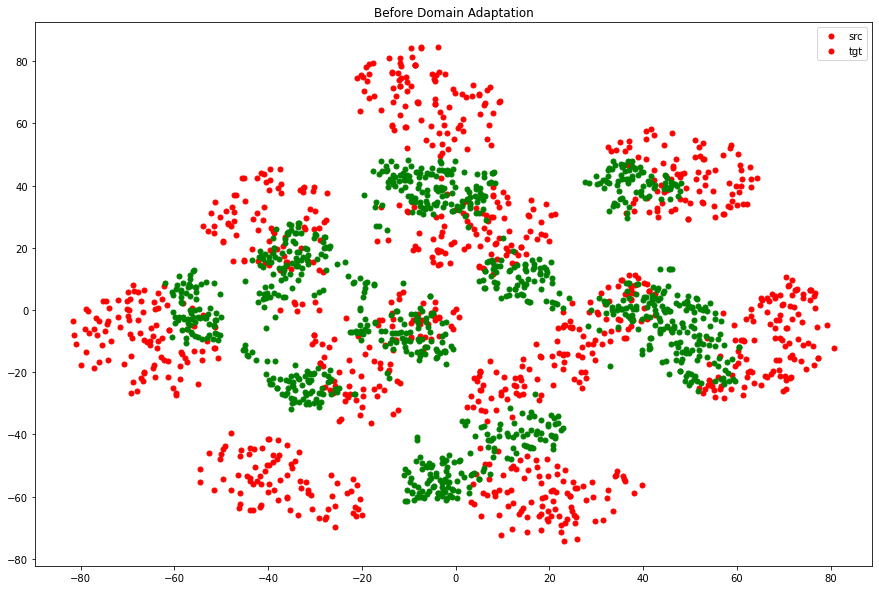

In [26]:
#with domain adapataion
for i in range(num_epoch):
        print("epoch={}".format(i))
        extractor_b, classifier_b1, classifier_b2 = train(src_train_data, tgt_train_data, extractor_b, classifier_b1, classifier_b2)

        torch.save(extractor_b, os.path.join(models_save, "extractor_b.pth"))
        torch.save(classifier_b1, os.path.join(models_save, "classifier_b1.pth"))
        torch.save(classifier_b2, os.path.join(models_save, "classifier_b2.pth"))

        if(i<num_epoch-1):
            # Source domain test
            test(src_test_data, extractor_b, classifier_b1, classifier_b2)
            # Target domain test
            test(tgt_test_data, extractor_b, classifier_b1, classifier_b2)
        else:
             # Source and target test and plot
            test_and_plot(src_test_data, tgt_test_data, extractor_b, classifier_b1, classifier_b2)

acc1=97.64%, acc2=97.55%
acc1=93.52%, acc2=92.63%
acc1=97.66%, acc2=97.59%


/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


acc1=93.07%, acc2=92.13%


/home/akash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


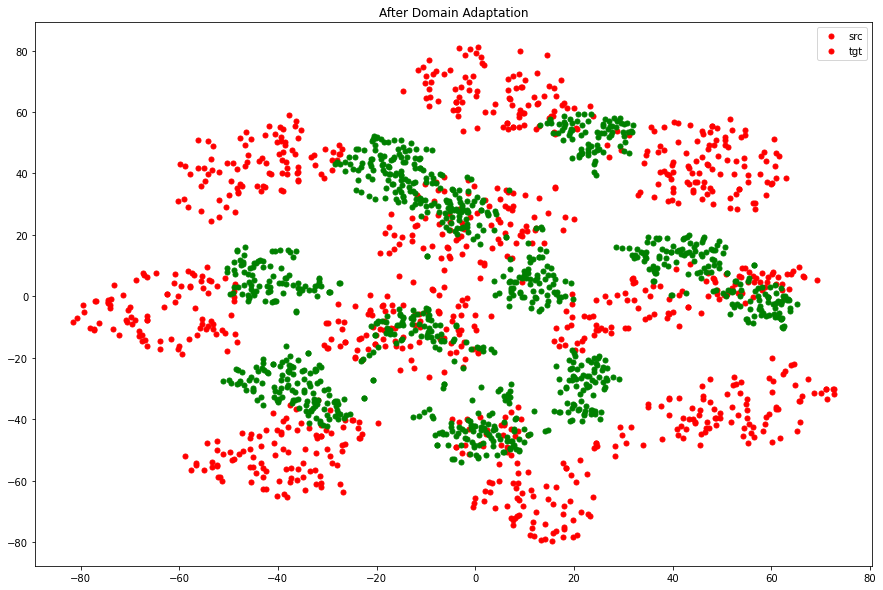

In [27]:
test(src_test_data, extractor_b, classifier_b1, classifier_b2)

test(tgt_test_data, extractor_b, classifier_b1, classifier_b2)

test_and_plot(src_test_data, tgt_test_data, extractor_b, classifier_b1, classifier_b2)

In [28]:
from cuml.manifold import TSNE

ModuleNotFoundError: No module named 'cuml'